# Data Preparation

In [25]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [42]:
dir = '/Users/Loielaine/Desktop/umich-2019/EECS545/project/code/545project/'
train = np.loadtxt(dir+'train_sample2.csv',delimiter=',')
test = np.loadtxt(dir+'test_sample2.csv',delimiter=',')

In [43]:
X_train = train[:,:35]
y_train = train[:,-2:]
X_test = test[:,:35]
y_test = test[:,-2:]

In [44]:
y_train0 = y_train[:,0]
y_train1 = y_train[:,1]

In [45]:
# scaling
def MinMaxScaling(X):
    scaler =preprocessing.MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

In [46]:
X_train = MinMaxScaling(X_train)
X_test = MinMaxScaling(X_test)

## Reshape data

In [47]:
# reshape feature matrix
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_train.shape

(10197, 1, 35)

In [48]:
# reshape feature matrix
X_test = X_test.reshape(X_test.shape[0], 1,X_test.shape[1])
X_test.shape

(2550, 1, 35)

# LSTM

In [49]:
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, TimeDistributed 

In [50]:
model = Sequential() #layers [1,50,50,50,50,1]
model.add(LSTM(input_shape=(1,35),units=100,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(input_shape=(None,100),units=50,return_sequences=True))
model.add(Dropout(0.3))
#model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))
# model.add(Activation("sigmoid"))
#start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
#print("Compilation Time : ", time.time() - start)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 100)            54400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [51]:
history = model.fit(X_train,y_train0,batch_size=24,epochs=100,validation_split=0.1)

Train on 9177 samples, validate on 1020 samples
Epoch 1/100
9177/9177 [==============================] - 6s 647us/step - loss: 216.7429 - val_loss: 256.5701
Epoch 2/100
9177/9177 [==============================] - 4s 462us/step - loss: 208.4965 - val_loss: 252.7779
Epoch 3/100
9177/9177 [==============================] - 5s 511us/step - loss: 207.1009 - val_loss: 251.6445
Epoch 4/100
9177/9177 [==============================] - 4s 472us/step - loss: 204.4278 - val_loss: 248.3657
Epoch 5/100
9177/9177 [==============================] - 4s 396us/step - loss: 201.9950 - val_loss: 246.2750
Epoch 6/100
9177/9177 [==============================] - 4s 401us/step - loss: 198.1669 - val_loss: 245.4530
Epoch 7/100
9177/9177 [==============================] - 3s 305us/step - loss: 193.7579 - val_loss: 241.1723
Epoch 8/100
9177/9177 [==============================] - 3s 291us/step - loss: 191.7306 - val_loss: 240.6241
Epoch 9/100
9177/9177 [==============================] - 3s 355us/step - loss: 1

9177/9177 [==============================] - 2s 242us/step - loss: 141.5817 - val_loss: 186.3213
Epoch 76/100
9177/9177 [==============================] - 2s 238us/step - loss: 140.1158 - val_loss: 181.9060
Epoch 77/100
9177/9177 [==============================] - 2s 235us/step - loss: 140.7665 - val_loss: 185.3654
Epoch 78/100
9177/9177 [==============================] - 2s 236us/step - loss: 142.0985 - val_loss: 180.5936
Epoch 79/100
9177/9177 [==============================] - 2s 233us/step - loss: 140.3222 - val_loss: 181.7262
Epoch 80/100
9177/9177 [==============================] - 2s 236us/step - loss: 139.7914 - val_loss: 188.2124
Epoch 81/100
9177/9177 [==============================] - 2s 235us/step - loss: 140.3491 - val_loss: 183.1895
Epoch 82/100
9177/9177 [==============================] - 2s 234us/step - loss: 138.0794 - val_loss: 178.7685
Epoch 83/100
9177/9177 [==============================] - 2s 233us/step - loss: 139.8357 - val_loss: 179.8672
Epoch 84/100
9177/9177 

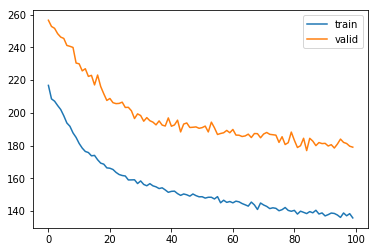

In [52]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [53]:
mse = mean_squared_error(y_test[:,0],model.predict(X_test)[:,0])

In [54]:
mse

153.65145761460568

In [55]:
y_pred0 = model.predict(X_test)[:,0]

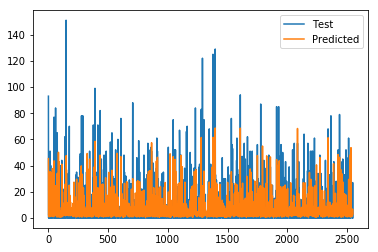

In [56]:
plt.plot(y_test[:,0],label='Test')
plt.plot(y_pred0,label='Predicted')
plt.legend()
plt.show()